![BPTK Quickstart](./images/hero.svg)

The Business Prototyping Toolkit (BPTK) is a computational modeling framework that enables you to build simulation models using System Dynamics (SD) and/or agent-based modeling (ABM) and manage simulation scenarios with ease.

The framework is used to build models of markets, business models, organisations and entire business ecosystems. It can be used to build small, explorative models (as illustrated here) as well as large models with hundreds of thousands of equations.

The guiding principle of the framework is to let the modeler concentrate on building simulation models by providing a seamless interface for managing model settings and scenarios and for plotting simulation results. It takes a "minimalistic" approach and just provides the necessary modeling and simulation functionality. It standard open source packages for everything else, in particular it relies on environments such as Jupyter to provide plotting and interactive dashboards.

* All plotting is done using Matplotlib.
* Simulation results are returned as Pandas dataframes.
* Numerics via NumPy and SciPy.


Model settings and scenarios are kept in JSON files. These settings are automatically loaded by the framework upon initialization, as are the model classes themselves. This makes interactive modeling, coding and testing very painless, especially if using the Jupyter notebook environment.


# Key Components of the Business Prototyping Toolkit

The toolkit has been available since 2018 and meanwhile offers modeling in Python for Agent-based modeling (ABM), System Dynamics Modeling (SD) and hybrid modeling using both SD and ABM.

There is also support for importing XMILE models created with external modeling environments, such as [iseesystems](https://www.iseesystems.com) Stella Architect or iThink modeling envirnoments.

Once you have a model, you can then define and manage different simulation scenarios, plot the results of those scenarios and build interactive dashboards.

The framework also provides a simple REST API server which easily lets you serve up and query models using web technology. You can then use the BPTK Widget Library to build web dashboards.

![BPTK Building Blocks](./images/bptk_components.svg)

You can view an example dashboard illustrating different COVID-Scenarios [online](http://www.covid-sim.com), the respositories for the [dashboard](https://github.com/transentis/sim-covid-dashboard) and [simulation](https://github.com/transentis/sim-covid-19) are available on [GitHub](https://github.com/transentis/).

# Example Model: Simulating Customer Acquisition using the Bass Diffusion Model

To illustrate the different ways of building simulation models using BPTK, we will use a simple model of customer acquistion known as the [Bass Diffusion Model](https://en.wikipedia.org/wiki/Bass_diffusion_model). It describes the process of how new products or services are adopted by consumers.

We will build the model using the System Dynamics DSL, using Agent-based modelling, using a hybrid ABM and SD DSL model and using a XMILE.

The basic structure of the model is illustrated in the following causal loop diagram:

![Customer Acquisition CLD](./images/customer_acquisition_cld.svg)

# Building the Customer Acquisition Model with SD DSL

Based on the causal loop diagram, we will implement a stock and flow model with the following stocks, flows, converters and constants:

![Customer Acquisition CLD](./images/customer_acquisition_stock_flow.svg)

## Building The Model

Setting up the model using the SD DSL is quite easy. We first instantiate a model class, which will be the container that holds the model elements. This ensures you can run multiple models in parallel.

In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

In [2]:
model = Model(starttime=1.0,stoptime=60.0, dt=1.0, name="Customer Acquisition SDDSL")

In [3]:
# stocks
customers = model.stock("customers")
potential_customers = model.stock("potential_customers")

In [4]:
#flows
customer_acquisition=model.flow("customer_acquisition")

In [5]:
#converters
acquisition_through_advertising = model.converter("acquisition_through_advertising")
acquisition_through_word_of_mouth = model.converter("acquisition_through_word_of_mouth")
consumers_reached_through_advertising = model.converter("consumers_reached_through_advertising")
consumers_reached_through_word_of_mouth= model.converter("consumers_reached_through_word_of_mouth")
market_saturation = model.converter("market_saturation")

In [6]:
#constants
initial_customers = model.constant("initial_customers") 
initial_potential_customers = model.constant("initial_potential_customers") 
advertising_success = model.constant("advertising_success")
consumers_reached_per_euro = model.constant("consumers_reached_per_ruro")
advertising_budget = model.constant("advertising_budget")
word_of_mouth_success = model.constant("word_of_mouth_success")
contact_rate = model.constant("contact_rate")

Now that we have defined all the model elements, we need to define the actual equations. The neat thing is that we can write these equations directly using the model elements.

In [7]:
#equations
customers.equation = customer_acquisition
potential_customers.equation = -customer_acquisition
customer_acquisition.equation=sd.min(potential_customers,acquisition_through_advertising+acquisition_through_word_of_mouth)
acquisition_through_advertising.equation = advertising_success*consumers_reached_through_advertising
consumers_reached_through_advertising.equation = consumers_reached_per_euro*advertising_budget*(1-market_saturation)
market_saturation.equation = customers/(customers+potential_customers)
acquisition_through_word_of_mouth.equation = word_of_mouth_success*consumers_reached_through_word_of_mouth
consumers_reached_through_word_of_mouth.equation=contact_rate*customers*(1-market_saturation)

We also need to initiale the stocks and set the constants.

In [8]:
#initialize model
customers.initial_value=initial_customers
potential_customers.initial_value=initial_potential_customers
initial_customers.equation = 0.0
initial_potential_customers.equation = 60000.0
advertising_success.equation = 0.1
consumers_reached_per_euro.equation = 100.0
advertising_budget.equation = 100.0
word_of_mouth_success.equation = 0.01
contact_rate.equation = 10.0

The model is now complete and we can directly plot the behavour of the model elements over time:

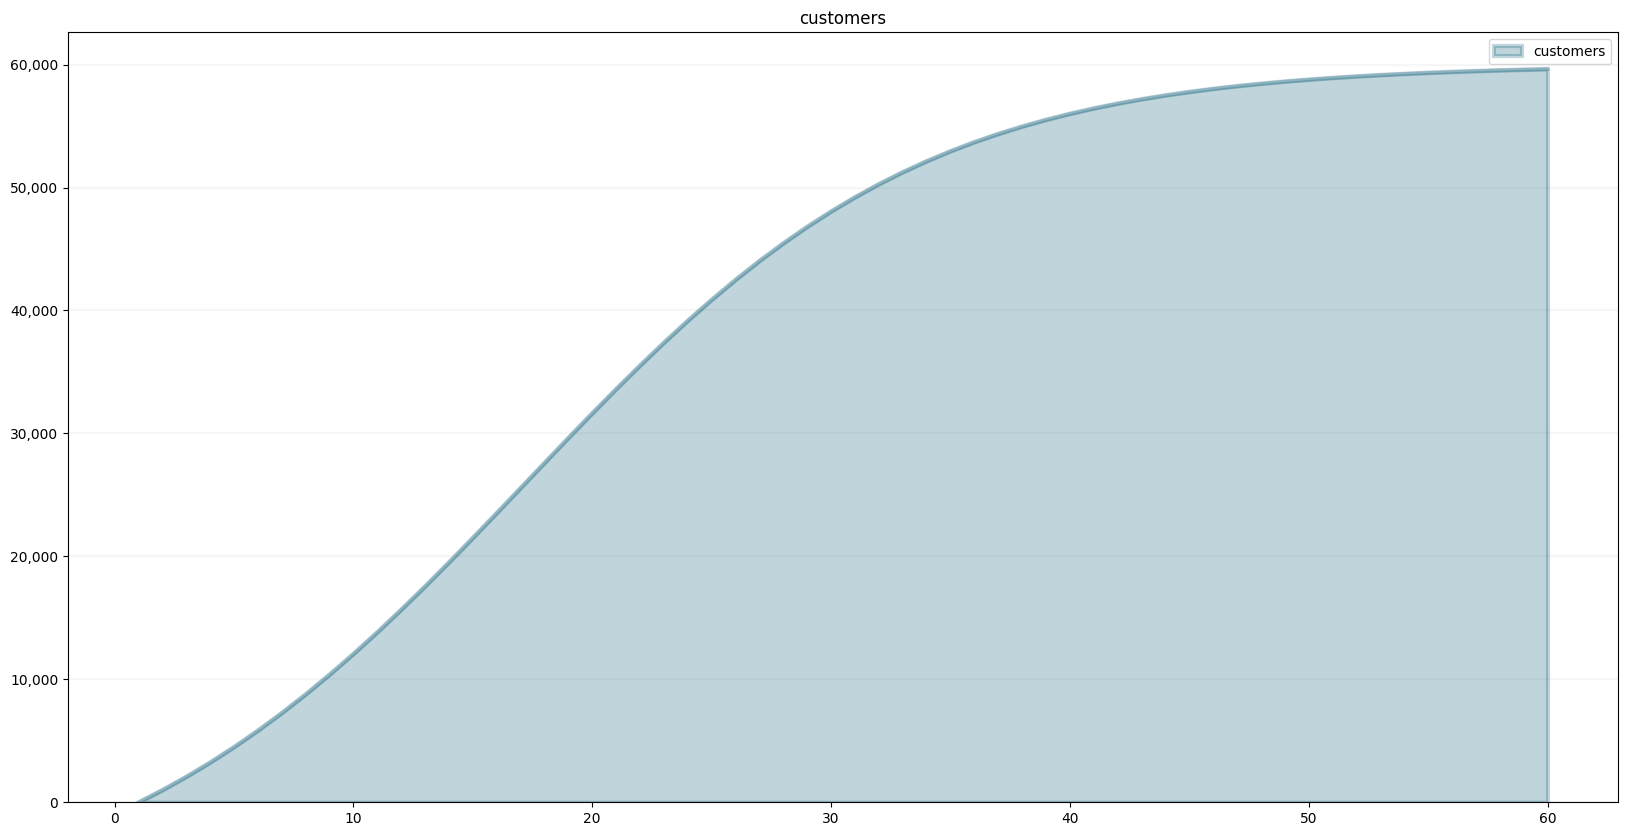

In [9]:
customers.plot()

Of course you can also access the underlying Pandas dataframe:

In [10]:
customers.plot(return_df=True)[1:10]

,customers
1.0,0.000000
2.0,1000.000000
3.0,2081.666667
4.0,3247.916662
5.0,4500.994779
6.0,5842.312754
7.0,7272.284453
8.0,8790.164623
9.0,10393.900018
10.0,12080.003090


For debugging purposes it can be useful to take a look at the internat representation of the model equations - these are stored as Python lambda functions.

In [11]:
customers.function_string

"lambda model, t : ( (model.memoize('initial_customers',t)) if (t <= model.starttime) else (model.memoize('customers',t-model.dt))+ model.dt*(model.memoize('customer_acquisition',t-model.dt)) )"

In [12]:
customer_acquisition.function_string

"lambda model, t : max( 0,min( model.memoize('potential_customers',t), model.memoize('acquisition_through_advertising',t)+model.memoize('acquisition_through_word_of_mouth',t)))"

## Setting Up Scenarios

Scenarios are just particular settings for the constants and graphical functions in your model and scenario managers are a simple way of grouping scenarios.

You can create scenarios directly in Python (which we will do here), but the easiest way to maintain them is to keep them in separate JSON files – you can define as many scenario managers and scenarios in a file as you would like and use as many files as you would like.

Each scenario manager references the model it pertains to. So you can run multiple simulation models in one notebook.

All the scenario definition files are kept in the scenarios/ folder. The BPTK_Py framework will automatically scan this folder and load the scenarios – including the underlying simulation models – into memory.

In [13]:
scenario_manager={
    "sddsl_customer_acquisition":{
        "model":model,
        "base_constants":{
            "initial_customers" : 0.0,
            "initial_potential_customers" : 60000.0,
            "advertising_success": 0.1,
            "consumers_reached_per_euro" : 100.0,
            "advertising_budget" : 100.0,
            "word_of_mouth_success": 0.01,
            "contact_rate" : 10.0
        }
    }
}

To manage the scenarios you need to instantiate the bptk class - this class stores the scenario managers and scenarios and provides lot's of convenient functions to plot data, export model results or import data.

In [14]:
import BPTK_Py
bptk = BPTK_Py.bptk()

In [15]:
bptk.register_scenario_manager(scenario_manager)

A convenient feature of scenarios is that you only have to define variables that change - essentially the scenario manager first takes the constants as set in the model itself and then overrides them with the settings from the scenario.

In [16]:
bptk.register_scenarios(
    
    scenario_manager="sddsl_customer_acquisition",
    scenarios=
    {
        "base":{
            
        },
        "low_word_of_mouth":{
            "constants":{
                "word_of_mouth_success":0.001
            }
        },
        "high_word_of_mouth":{
            "constants":{
                "word_of_mouth_success":0.1
            }
        },
        "interactive_scenario":{}
        
    }
    

)

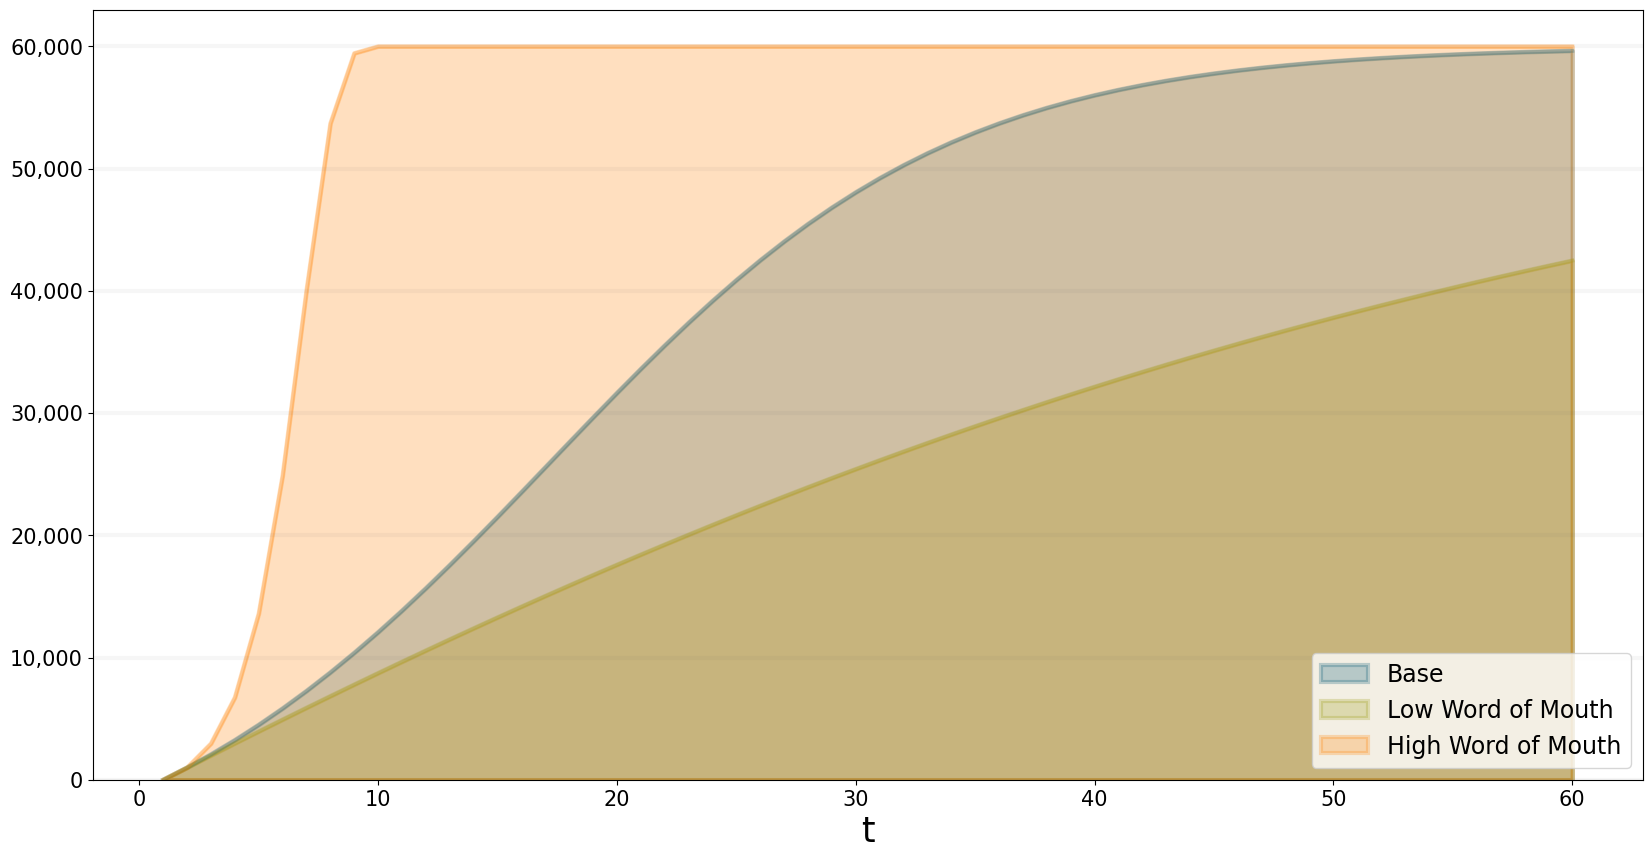

In [17]:
bptk.plot_scenarios(
    scenario_managers=["sddsl_customer_acquisition"],
    scenarios=["base","low_word_of_mouth","high_word_of_mouth"],
    equations=["customers"],
    series_names={
        "sddsl_customer_acquisition_base_customers":"Base",
        "sddsl_customer_acquisition_low_word_of_mouth_customers":"Low Word of Mouth",
        "sddsl_customer_acquisition_high_word_of_mouth_customers":"High Word of Mouth",
    }
)

In [18]:
bptk.get_scenario_names([],format="dict")

{'xmile_customer_acquisition': ['base',
  'low_word_of_mouth',
  'high_word_of_mouth'],
 'sddsl_customer_acquisition': ['base',
  'low_word_of_mouth',
  'high_word_of_mouth',
  'interactive_scenario']}

## Building An Interactive UI

It is easy to build interactive dashboards in Jupyter using IPywidgets – all you need from BPTK is the ability to plot graphs. 

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

In [20]:
customerTab = widgets.Output()
customerAcquisitionTab = widgets.Output()
scenariosTab = widgets.Output()


tabs = widgets.Tab(children = [customerTab, customerAcquisitionTab,scenariosTab])
tabs.set_title(0, 'Customers')
tabs.set_title(1, 'Customer Acquisition')
tabs.set_title(2, 'Scenarios')
display(tabs)

@interact(word_of_mouth_success=widgets.FloatSlider(
    value=0.01,
    min=0.001,
    max=0.1,
    step=0.001,
    continuous_update=False,
    description='Word Of Mouth Success'
))
def dashboardWithTabs(word_of_mouth_success):
    scenario= bptk.get_scenario("sddsl_customer_acquisition","interactive_scenario")
    
    scenario.constants["word_of_mouth_success"]=word_of_mouth_success
    bptk.reset_scenario_cache(scenario_manager="sddsl_customer_acquisition",
                                                             scenario="interactive_scenario")



    with customerTab:
        # turn of pyplot's interactive mode to ensure the plot is not created directly
        plt.ioff()
        # clear the widgets output ... otherwise we will end up with a long list of plots, one for each change of settings
        customerTab.clear_output()
        # create the plot, but don't show it yet
        bptk.plot_scenarios(
            scenario_managers=["sddsl_customer_acquisition"],
            scenarios=["interactive_scenario"],
            equations=['customers'],
            title="Customers",
            freq="M",
            x_label="Time",
            y_label="No. of Customers"
            )
        # show the plot
        plt.show()
        # turn interactive mode on again
        plt.ion()

    with customerAcquisitionTab:
        plt.ioff()
        customerAcquisitionTab.clear_output()
        bptk.plot_scenarios(
            scenario_managers=["sddsl_customer_acquisition"],
            scenarios=["interactive_scenario"],
            equations=['customer_acquisition'],
            title="Customer Acquisition",
            freq="M",
            x_label="Time",
            y_label="No. of Customers"
            )
        plt.show()
        plt.ion()
    
    with scenariosTab:
        plt.ioff()
        scenariosTab.clear_output()
        bptk.plot_scenarios(
            scenario_managers=["sddsl_customer_acquisition"],
            scenarios=["base","low_word_of_mouth","high_word_of_mouth","interactive_scenario"],
            equations=["customers"],
            series_names={
                "sddsl_customer_acquisition_base_customers":"Base",
                "sddsl_customer_acquisition_interactive_scenario_customers":"Interactive",
                "sddsl_customer_acquisition_low_word_of_mouth_customers":"Low Word of Mouth",
                "sddsl_customer_acquisition_high_word_of_mouth_customers":"High Word of Mouth",
        })
        plt.show()
        plt.ion()

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='Word Of Mouth Success', ma…

# Customer Acquisition using Agent-based Modeling

The basic concept behind Agent-based models is quite simple: you populate an environment (the model) with a set of agents. Agents and the environment each have a set of properties and each agent must always be in a defined state.

Agents can perform actions and interact amongst each other and with the environment by sending each other events - the agents react to these events by updating their properties and/or changing their state.

![Agents and their environment](./images/agents_environment.svg)

So to create an agent using Python and the BPTK framework, all you really need to do is:

* Identify the relevant agents
* Define the agents properties 
* For each agent, implement an initializer which sets the agents initial state
* Define handlers for each kind of event you want your agent to react to
* Define an action method, which describes what the agent does in each time-step, e.g. perform internal tasks and send events to other agents

Defining the model is even easier:

* Define the environment properties and update them when necessary
* Tell the model which kinds of agents there are
* Then, to configure the simulation, all we need to do is to set the initial values of the properties and instantiate the initial agents. Each unique configuration of a model is refered to as a scenario. The BPTK framework helps you to manage different scenarios and compare results easily.

Configuring Agent-based models is best done using a config file defined in JSON.

Agent-based modeling is a very powerful approach and you can build models using ABM that you cannot build using SD. This power comes at a prices though: because each agent is modelled as an individual entity, agent-based models are quite slow.

## Setting Up the Model

For the customer acquisition model, we really just need to agents: the company that sends advertising events and the consumers that receive those events. If a consumer becomes a customer, then the consumers starts sending word ouf mouth events.

This is illustrated in the following diagram:

![Customer Acquisition ABM](./images/customer_acquisition_abm.svg)

Note that the advertising budget and the contact rate are properties of the respective agents – this is a glimpse at the power of agent-based modeling, because we could easily set individual contact rates for the consumers or have multiple companies advertising competing products. All these aspects cannot easily be modelled using System Dynamics.

In [21]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

In [22]:
from BPTK_Py import Agent
from BPTK_Py import Model
from BPTK_Py import Event
from BPTK_Py import DataCollector
from BPTK_Py import SimultaneousScheduler

Setting up agents is actually quite simple - all you need to do is register handlers for the events and define the `act` method.

In [23]:
class Consumer(Agent):
    def initialize(self):
        self.agent_type = "consumer"
        self.state = "potential"
        self.register_event_handler(["potential"],"advertising_event",self.handle_advertising_event)
        self.register_event_handler(["potential"],"word_of_mouth_event",self.handle_word_of_mouth_event)
        
    def handle_advertising_event(self,event):
        if self.is_event_relevant(self.model.advertising_success):
            self.state="customer"
    
    def handle_word_of_mouth_event(self, event):
        if self.is_event_relevant(self.model.word_of_mouth_success):
            self.state="customer"
                
    def act(self,time,round_no,step_no):
        # consumers who are customers generate word of mouth events
        if self.state == "customer":
            self.model.random_events(
                "consumer",
                self.contact_rate,
                lambda agent_id: Event("word_of_mouth_event", self.id, agent_id)
            )

Note that the company agent defined below accesses the properties `advertising_budget`and `consumers_reacher_per _euro`. These properties are defined in the scenarios and can then be accessed "magically" as either agent properties or model properties.

In [24]:
class Company(Agent):
    def initialize(self):
            self.agent_type="company"
            self.state = "active"
    
    def act(self,time,round_no,step_no):
        self.model.random_events(
            "consumer",
            self.advertising_budget*self.model.consumers_reached_per_euro,
            lambda agent_id: Event("advertising_event",self.id, agent_id)
        )

The model itself needs a way of instantiating agents - for this you register agent factories, which return an agent of a particular type. In their simplest form an agent factory is just a lambda function.

In [25]:
class CustomerAcquisitionAbm(Model):
    def instantiate_model(self):
        self.register_agent_factory("consumer", lambda agent_id,model,properties: Consumer(agent_id, model,properties))
        self.register_agent_factory("company", lambda agent_id,model, properties: Company(agent_id, model, properties))

In [26]:
customer_acquisition_abm=CustomerAcquisitionAbm(1,60,dt=1,name="Customer Acquisition Agent-based Model",scheduler=SimultaneousScheduler(),data_collector=DataCollector())

In [27]:
customer_acquisition_abm.instantiate_model()

In [28]:
customer_acquisition_abm_config =  {
             "runspecs": {
                  "starttime": 1,
                  "stoptime":60,
                  "dt": 1.0
            },
            "properties":
            {
                "word_of_mouth_success":
                {
                    "type":"Double",
                    "value":0.01
                },
                "advertising_success":
                {
                    "type":"Double",
                    "value":0.1
                },
                "consumers_reached_per_euro":
                {
                    "type":"Integer",
                    "value":100
                }
                
            },
            "agents":
            [
                {
                    "name":"company",
                    "count":1,
                    "properties":{
                         "advertising_budget":
                        {
                            "type":"Integer",
                            "value":100
                        }
                    }
                },
                {
                    "name":"consumer",
                    "count":60000,
                    "properties":{
                        "contact_rate":
                        {
                        "type":"Integer",
                        "value":10
                        }
                    }
                        
                }
            ]
        }

In [29]:
customer_acquisition_abm.configure(customer_acquisition_abm_config)

NOTE: Running the agent-based model takes a little time, ca. 3 min on my machine. 

In [30]:
customer_acquisition_abm.run()

In [31]:
[customer_acquisition_abm.statistics().get(1.0*key) for key in range(1,5)]

[{'company': {'active': {'count': 1,
    'advertising_budget': {'total': 100,
     'max': 100,
     'min': 100,
     'mean': 100.0}}},
  'consumer': {'potential': {'count': 60000,
    'contact_rate': {'total': 600000, 'max': 10, 'min': 10, 'mean': 10.0}}}},
 {'company': {'active': {'count': 1,
    'advertising_budget': {'total': 100,
     'max': 100,
     'min': 100,
     'mean': 100.0}}},
  'consumer': {'potential': {'count': 59028,
    'contact_rate': {'total': 590280, 'max': 10, 'min': 10, 'mean': 10.0}},
   'customer': {'count': 972,
    'contact_rate': {'total': 9720, 'max': 10, 'min': 10, 'mean': 10.0}}}},
 {'company': {'active': {'count': 1,
    'advertising_budget': {'total': 100,
     'max': 100,
     'min': 100,
     'mean': 100.0}}},
  'consumer': {'potential': {'count': 57961,
    'contact_rate': {'total': 579610, 'max': 10, 'min': 10, 'mean': 10.0}},
   'customer': {'count': 2039,
    'contact_rate': {'total': 20390, 'max': 10, 'min': 10, 'mean': 10.0}}}},
 {'company': {'a

## Setting Up Scenarios

The scenario mechanism works exactly the same for SD DSL, Agent-based an hybrid models. This ensures that you can keep load different kinds of models and compare results! 

In [32]:
import BPTK_Py
bptk = BPTK_Py.bptk()

In [33]:
customer_acquisition_abm.reset()

In [34]:
abm_scenario_manager={
    "abm_customer_acquisition":{
        "name":"abm_customer_acquisition",
        "type":"abm",
        "model":customer_acquisition_abm,
        "scenarios":{
            "base":
        {
             "runspecs": {
                  "starttime": 1,
                  "stoptime":60,
                  "dt": 1.0
            },
            "properties":
            {
                "word_of_mouth_success":
                {
                    "type":"Double",
                    "value":0.01
                },
                "advertising_success":
                {
                    "type":"Double",
                    "value":0.1
                },
                "consumers_reached_per_euro":
                {
                    "type":"Integer",
                    "value":100
                }
                
            },
            "agents":
            [
                {
                    "name":"company",
                    "count":1,
                    "properties":{
                         "advertising_budget":
                        {
                            "type":"Integer",
                            "value":100
                        }
                    }
                },
                {
                    "name":"consumer",
                    "count":60000,
                    "properties":{
                         "contact_rate":
                         {
                            "type":"Integer",
                            "value":10
                        }
                        
                    }
                }
            ]
        }
        }
    }
    
    
}


In [35]:
bptk.register_scenario_manager(abm_scenario_manager)

Output()

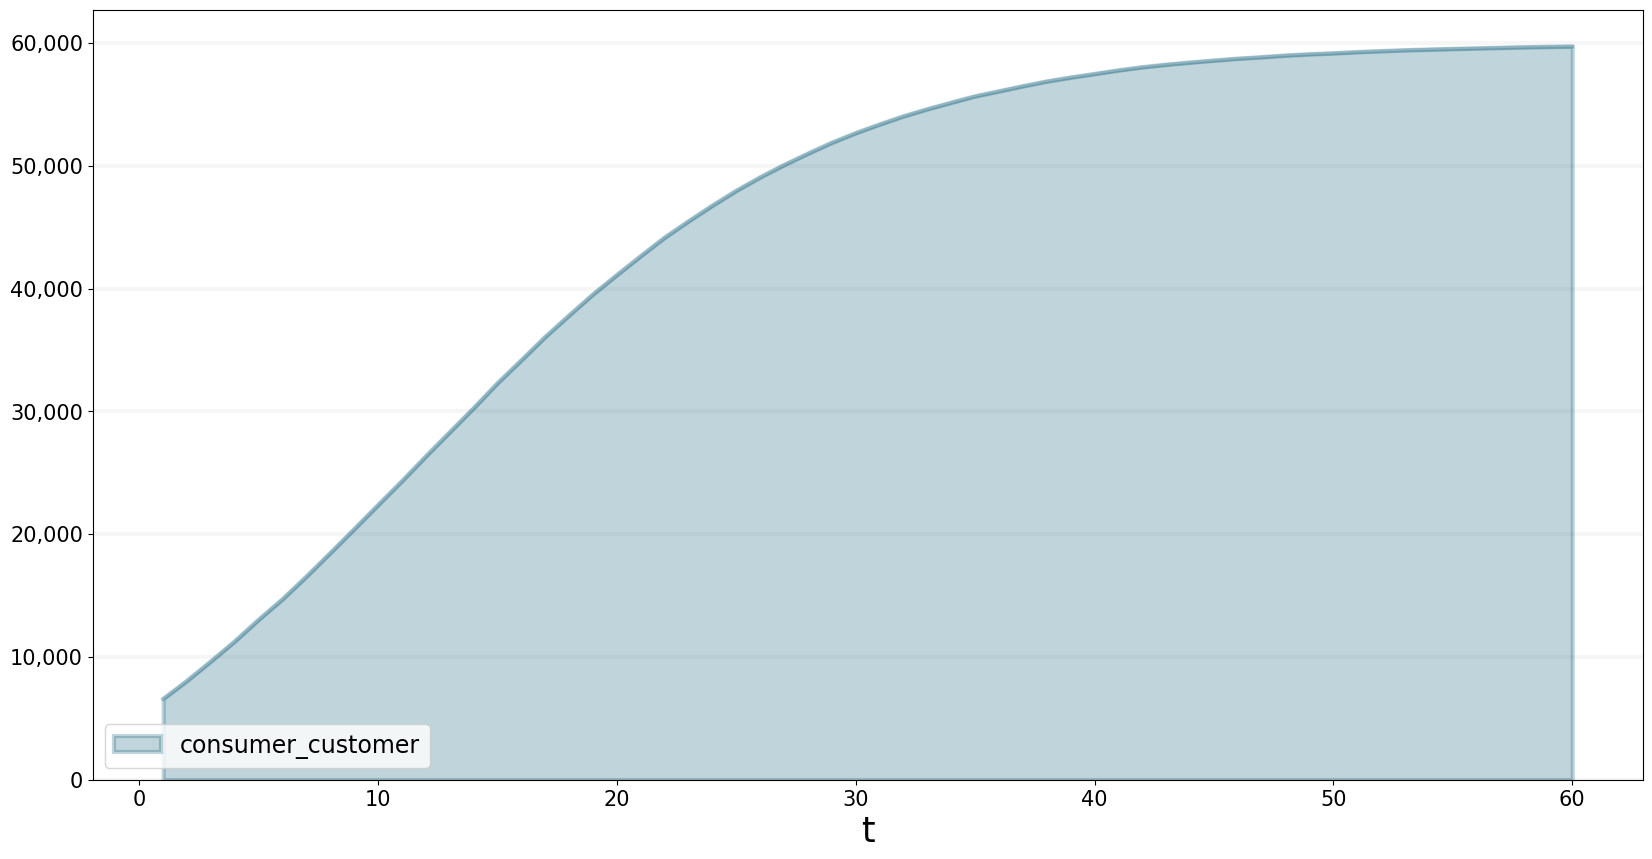

In [36]:
bptk.plot_scenarios(
    scenario_managers=["abm_customer_acquisition"],
    scenarios=["base"],
    agents=["consumer"],
    agent_states=["customer"],
    progress_bar=True
)   

NOTE: especially for larger models it is much better to keep the model and the scenario definitions in separate files.

# The Best of Both Worlds: Hybrid ABM and SD Models

Hybrid models are agent based models that "contain" a System Dynamics model. The agents can call the elements of the SD model. The SD model elements can also call properties on the agent-based model via user defined sd functions.

## Setting Up The Model

In [37]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

In [38]:
from BPTK_Py import Agent
from BPTK_Py import Model
from BPTK_Py import Event
from BPTK_Py import DataCollector
from BPTK_Py import SimultaneousScheduler

In [39]:
class Customer(Agent):
    def initialize(self):
        self.agent_type = "customer"
        self.state = "active"

The following code illustrates how to set up a system dynamics model as a Python class.

In [40]:
class CustomerAcquisitionSD():
    def __init__(self,model):
        self.model = model
        
        # stocks
        self.customers = model.stock("customers")
        
        #flows
        self.customer_acquisition=model.flow("customer_acquisition")
        
        #converters
        self.acquisition_through_advertising = model.converter("acquisition_through_advertising")
        self.acquisition_through_word_of_mouth = model.converter("acquisition_through_word_of_mouth")
        self.consumers_reached_through_advertising = model.converter("consumers_reached_through_advertising")
        self.consumers_reached_through_word_of_mouth= model.converter("consumers_reached_through_word_of_mouth")
        self.market_saturation = model.converter("market_saturation")
        
        #constants
        self.initial_customers = model.constant("initial_customers") 
        self.target_market= model.constant("target_market")
        self.advertising_success = model.constant("advertising_success")
        self.consumers_reached_per_euro = model.constant("consumers_reached_per_ruro")
        self.advertising_budget = model.constant("advertising_budget")
        self.word_of_mouth_success = model.constant("word_of_mouth_success")
        self.contact_rate = model.constant("contact_rate")
        
        #equations
        self.customers.equation = self.customer_acquisition
        self.customer_acquisition.equation=self.acquisition_through_advertising+self.acquisition_through_word_of_mouth
        self.acquisition_through_advertising.equation = self.advertising_success*self.consumers_reached_through_advertising
        self.consumers_reached_through_advertising.equation = self.consumers_reached_per_euro*self.advertising_budget*(1-self.market_saturation)
        self.market_saturation.equation = self.customers/self.target_market
        self.acquisition_through_word_of_mouth.equation = self.word_of_mouth_success*self.consumers_reached_through_word_of_mouth
        self.consumers_reached_through_word_of_mouth.equation=self.contact_rate*self.customers*(1-self.market_saturation)
        
        #initialize model
        self.customers.initial_value=self.initial_customers
        self.initial_customers.equation = 0.0
        self.target_market.equation = 60000.0
        self.advertising_success.equation = 0.1
        self.consumers_reached_per_euro.equation = 1.0
        self.advertising_budget.equation = 100.0
        self.word_of_mouth_success.equation = 0.01
        self.contact_rate.equation = 1.0
        

In [41]:
class CustomerAcquisitionHybrid(Model):
    def instantiate_model(self):
        super().instantiate_model()
        # register agent factories
        self.register_agent_factory("customer", lambda agent_id,model,properties: Customer(agent_id, model,properties))
        
        # set up the sd model - keep it in its own class so we can use the SD DSL
         
        self.sd_model = CustomerAcquisitionSD(self)
      
    def configure(self,config):
        super().configure(config)
        
        ## the config sets the model properties, which we need to set the initial values of the sd model
        self.sd_model.target_market.equation = self.target_market
        self.sd_model.advertising_success.equation = self.advertising_success
        self.sd_model.consumers_reached_per_euro.equation = self.consumers_reached_per_euro
        self.sd_model.advertising_budget.equation = self.advertising_budget
        self.sd_model.word_of_mouth_success.equation = self.word_of_mouth_success
        self.sd_model.contact_rate.equation = self.contact_rate
        
        
        
    def begin_round(self, time, sim_round, step):
        # at the beginning of each round we check to see how many customers we should have according to the
        # SD model and then create the right number of agents.
        
        required_num_customers = int(self.evaluate_equation("customers",time))
        current_num_customers = self.agent_count("customer")
        agents_needed = required_num_customers-current_num_customers
        self.create_agents({"name":"customer","count":agents_needed})
        
    
        

In [42]:
customer_acquisition_hybrid=CustomerAcquisitionHybrid(1,60,dt=1,name="Customer Acquisition Hybrid",scheduler=SimultaneousScheduler(),data_collector=DataCollector())

In [43]:
customer_acquisition_hybrid.instantiate_model()

In [44]:
customer_acquisition_hybrid_config =  {
             "runspecs": {
                  "starttime": 1,
                  "stoptime":60,
                  "dt": 1.0
            },
            "properties":
            {
                 "word_of_mouth_success":
                {
                    "type":"Double",
                    "value":0.01
                },
                "advertising_success":
                {
                    "type":"Double",
                    "value":0.1
                },
                "consumers_reached_per_euro":
                {
                    "type":"Double",
                    "value":100.0
                },
                "advertising_budget":
                {
                    "type":"Double",
                    "value":100.0
                },
                "contact_rate":
                {
                    "type":"Double",
                    "value":10.0
                },
                "target_market":
                {
                    "type":"Double",
                    "value":60000.0
                }
                
            },
            "agents":
            [
                {
                    "name":"customer",
                    "count":0
                }
            ]
        }

In [45]:
customer_acquisition_hybrid.configure(customer_acquisition_hybrid_config)

In [46]:
customer_acquisition_hybrid.run()

In [47]:
[customer_acquisition_hybrid.statistics().get(1.0*key) for key in range(2,10)]

[{'customer': {'active': {'count': 1000}}},
 {'customer': {'active': {'count': 2081}}},
 {'customer': {'active': {'count': 3247}}},
 {'customer': {'active': {'count': 4500}}},
 {'customer': {'active': {'count': 5842}}},
 {'customer': {'active': {'count': 7272}}},
 {'customer': {'active': {'count': 8790}}},
 {'customer': {'active': {'count': 10393}}}]

## Setting Up Scenarios

In [48]:
import BPTK_Py
bptk = BPTK_Py.bptk()

In [49]:
customer_acquisition_hybrid.reset()

In [50]:
hybrid_scenario_manager={
    "hybrid_customer_acquisition":{
        "name":"hybrid_customer_acquisition",
        "type":"abm",
        "model":customer_acquisition_hybrid,
        "scenarios":{
            "base":
           {
             "runspecs": {
                  "starttime": 1,
                  "stoptime":60,
                  "dt": 1.0
            },
            "properties":
            {
                 "word_of_mouth_success":
                {
                    "type":"Double",
                    "value":0.01
                },
                "advertising_success":
                {
                    "type":"Double",
                    "value":0.1
                },
                "consumers_reached_per_euro":
                {
                    "type":"Double",
                    "value":100.0
                },
                "advertising_budget":
                {
                    "type":"Double",
                    "value":100.0
                },
                "contact_rate":
                {
                    "type":"Double",
                    "value":10.0
                },
                "target_market":
                {
                    "type":"Double",
                    "value":60000.0
                }
                
            },
            "agents":
            [
                {
                    "name":"customer",
                    "count":0
                }
                
            ]
        }
        }
    }   
}


In [51]:
bptk.register_scenario_manager(hybrid_scenario_manager)

Output()

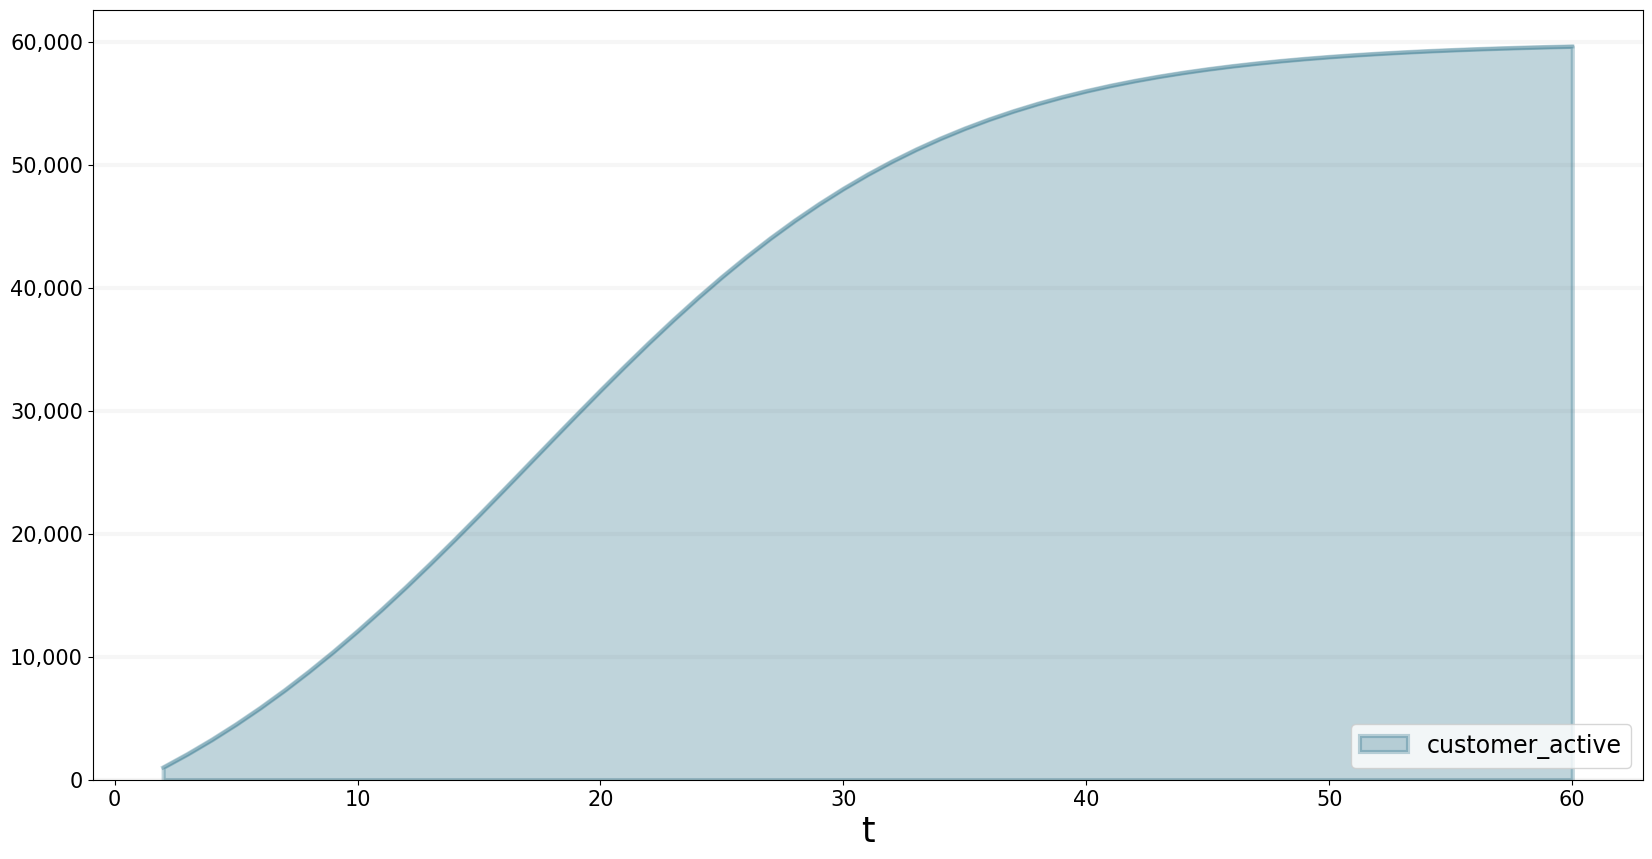

In [52]:
bptk.plot_scenarios(
    scenario_managers=["hybrid_customer_acquisition"],
    scenarios=["base"],
    agents=["customer"],
    agent_states=["active"],
    progress_bar=True
)   

NOTE: especially for larger models it is much better to keep the model and the scenario definitions in separate files, which of course is also possible. See the [Scenarios](../concepts/scenarios/scenarios.ipynb) document to learn more about this.

# XMILE Model

Many modelers prefer to build models using visual modeling environments and not directly in code. One such enviroment is Stella Architect. Using Stella Architect, you can build System Dynamics models visual. You can then import them into Python using BPTK and then work with them much like with any other model.

The framework automatically re-transpiles the XMILE model if changes are made in the visual modeling environment. So you can model in Stella Architect and experiment with scenarios in Jupyter.

Transpiled models work stand-alone, so you can run them anywhere independently of the modeling environment.

# Setting Up The Model

This is what our customer acquisition model looks like in Stella Architect:

![Stella Architect](./images/stella_architect.png)

## Setting Up The Scenarios

To work with XMILE models, all we have to do is set up a [scenario file](./scenarios/scenarios.json) in the `scenarios` folder.

The scenario file tells the framework where to find the [XMILE model](./simulation_models/customer_acquisition_xmile.stmx) and which scenarios to set up.

In our case the file looks like this - the only difference to the SD DSL scenario definition is the inclusion of the XMILE source.

```JSON
{
    "xmile_customer_acquisition":
    {
        "source":"simulation_models/customer_acquisition_xmile.stmx",
        "model":"simulation_models/customer_acquisition_xmile",
        "scenarios":
        {
          "base": { },
          
        "low_word_of_mouth":{
            "constants":{
                "wordOfMouthSuccess":0.001
            }
        },
        "high_word_of_mouth":{
            "constants":{
                "wordOfMouthSuccess":0.1
            }
        }
        }
    }
}

```

As soon as we instantiate bptk, the framework automatically searches the scenarios folder for scenarios and loads them.

In [53]:
import BPTK_Py
bptk = BPTK_Py.bptk()

Let's list all the scenarios and equations the framework finds.

In [54]:
bptk.list_equations(scenario_managers=["xmile_customer_acquisition"],scenarios=[])

Available Equations:

Scenario Manager: xmile_customer_acquisition
Scenario: base
--------------------------
	stock: 			customers
	stock: 			potentialCustomers
	flow: 			customerAcquisition
	converter: 		acquisitionThroughAdvertising
	converter: 		acquisitionThroughWordOfMouth
	converter: 		advertisingBudget
	converter: 		advertisingSuccess
	converter: 		consumersReachedPerEuro
	converter: 		consumersReachedThroughAdvertising
	converter: 		consumersReachedThroughWordOfMouth
	converter: 		contactRate
	converter: 		initialCustomers
	converter: 		initialPotentialCustomers
	converter: 		marketSaturation
	converter: 		wordOfMouthSuccess
 
Scenario: low_word_of_mouth
--------------------------
	stock: 			customers
	stock: 			potentialCustomers
	flow: 			customerAcquisition
	converter: 		acquisitionThroughAdvertising
	converter: 		acquisitionThroughWordOfMouth
	converter: 		advertisingBudget
	converter: 		advertisingSuccess
	converter: 		consumersReachedPerEuro
	converter: 		consumersReachedT

We directly plot the scenarios:

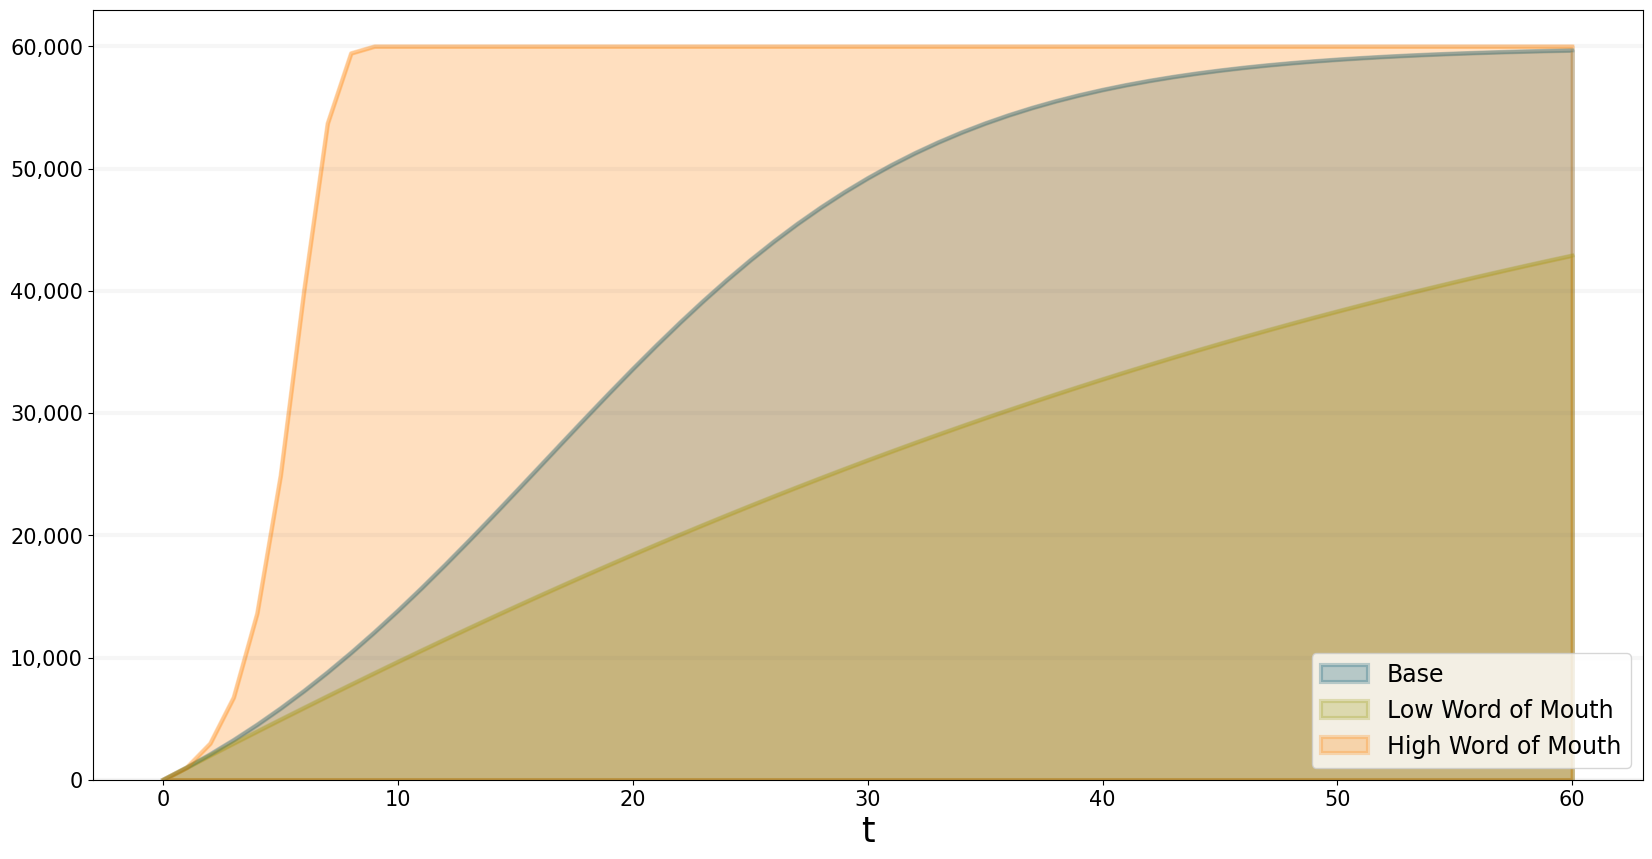

In [55]:
bptk.plot_scenarios(
    scenario_managers=["xmile_customer_acquisition"],
    scenarios=["base","high_word_of_mouth","low_word_of_mouth"],
    equations=["customers"],
    series_names={
                "xmile_customer_acquisition_base_customers":"Base",
                "xmile_customer_acquisition_low_word_of_mouth_customers":"Low Word of Mouth",
                "xmile_customer_acquisition_high_word_of_mouth_customers":"High Word of Mouth",
        }
)   

NOTE: Once the XMILE file has been transpiled into a Python model, the framework is independent of the XMILE file. All simulation is done in Python. The software that was used to create the XMILE file is not needed by the BPTK framework.

# Further Examples

You can find more examples in the [Model Library](../model_library/model_library.ipynb).

# Get In Touch

Please let us know if you need help getting started, if you find a bug or are missing important functionality.

A good place to get in touch is our [meetup group](https://www.transentis.com/business-prototyping-toolkit-meetup/en/), that gathers online monthly. This is a convenient setting to see BPTK in action, ask questions and suggest new features.

You can also reach us per e-mail at [support@transentis.com](mailto://support@transentis.com)